## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [11]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
import os
import librosa
os.environ["CUDA_VISIBLE_DEVICES"]="1" 


In [12]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [13]:
hparams = create_hparams()
hparams.sampling_rate = 16000

#### Load model from checkpoint

In [14]:
checkpoint_path = "./outputs/good/checkpoint_33000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

#### Prepare text input

In [42]:
text = "How long will it last, this ludicrous, overbearing love of ours"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

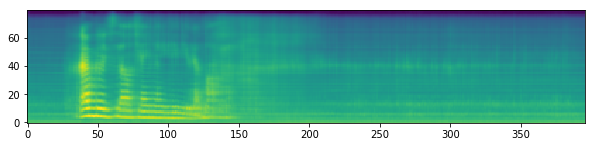

In [56]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plt.figure(figsize=(10, 4))
plt.imshow(mel_outputs.float().data.cpu().numpy()[0], origin='0')

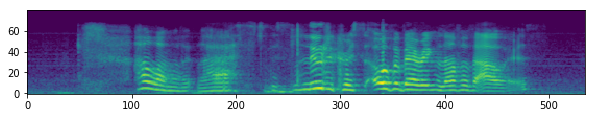

In [57]:
wav_path = '/data3/IEMOCAP/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F018.wav'
import librosa.display
y, sr = librosa.load(wav_path)
S = librosa.feature.melspectrogram(y=y, sr=16000, n_fft = 1024, hop_length=256, n_mels=80, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
plt.imshow(S_dB, origin='0')
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(S, ref=np.max)
# librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)

#### Synthesize audio from spectrogram using WaveGlow

In [8]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [9]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 